# GeoPandas IO   csv, shp geojson, etc

https://geohackweek.github.io/vector/04-geopandas-intro/


In [2]:
import os, sys,glob

import folium
from IPython.display import display

from shapely.geometry import mapping

%matplotlib inline

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

def csv2shp(csvfile):
    
    pdf = pd.read_csv(csvfile)
    mt_locations = [Point(xy) for xy in zip(pdf.lon, pdf.lat)]
    #OR pdf['geometry'] = pdf.apply(lambda z: Point(z.lon, z.lat), axis=1)
    #if you want to df = df.drop(['Lon', 'Lat'], axis=1)
    crs = {'init': 'epsg:4326'}  # WGS84
    crs = {'init': 'epsg:4283'}  # GGA94
    geo_df = gpd.GeoDataFrame(pdf, crs=crs, geometry=mt_locations)

    return geo_df

In [3]:
path2csv='E:/Data/MT_Datasets/WenPingJiang_SHP/PhaseTensorTipper_Params_1.0986Hz.csv'
path2dir=os.path.dirname(path2csv)
mygdf=csv2shp(path2csv)

In [4]:
# mygdf.head()
mygdf.shape

(137, 14)

In [5]:
mygdf.crs

{'init': 'epsg:4283'}

In [6]:
outshp=os.path.join(path2dir,'geopandas_made.shp')
mygdf.to_file(outshp, driver='ESRI Shapefile')


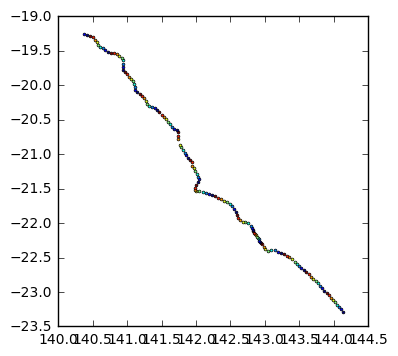

In [7]:
mygdf.plot()

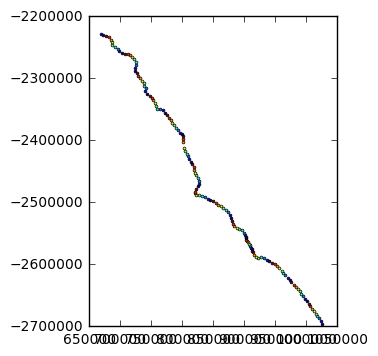

In [8]:
mygdf.to_crs({'init':'epsg:3112'}).plot()  # 3112 is GDA94/GALambertConformal

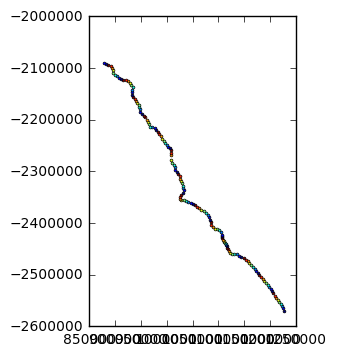

In [9]:
mygdf.to_crs({'init':'epsg:3577'}).plot()  #EPSG Projection 3577 - GDA94 / Australian Albers 

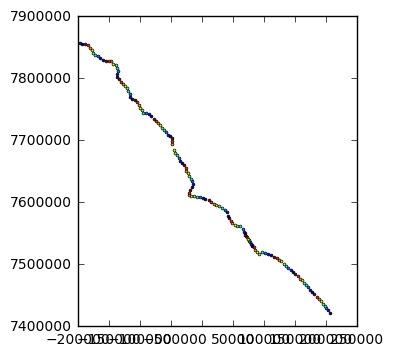

In [10]:
mygdf.to_crs({'init':'epsg:28355'}).plot() #28355 http://spatialreference.org/ref/epsg/gda94-mga-zone-55/

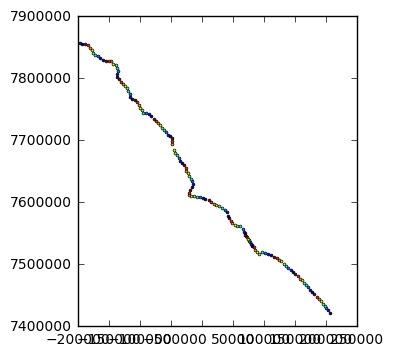

In [11]:
mygdf.to_crs({'init':'epsg:32755'}).plot() #32755 is WGS84/UTMS55

In [12]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'

#mpl.rcParams['figure.figsize']=(8,30)

In [13]:
gdf_utm54=mygdf.to_crs({'init':'epsg:32754'})  #.plot()

outshp=os.path.join(path2dir,'geopandas_made_utm54.shp')

gdf_utm54.to_file(outshp, driver='ESRI Shapefile')


In [14]:

geojson = mygdf.to_json()
bounds = mygdf.total_bounds


In [15]:
print bounds

(140.38040000000001, -23.288900000000002, 144.13800000000001, -19.2547)


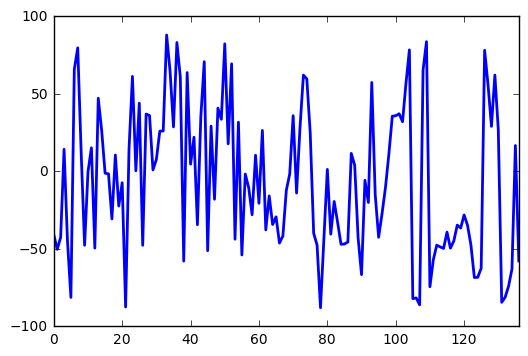

In [16]:
mygdf['azimuth'].plot()

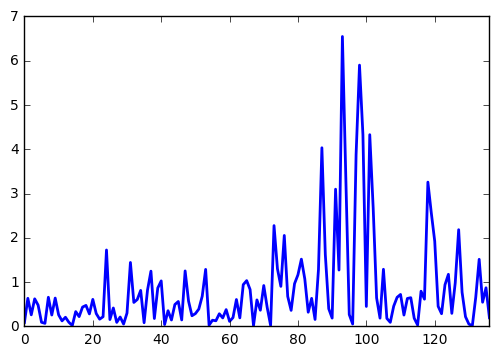

In [17]:
mygdf['skew'].abs().plot()

In [18]:
mygdf.columns

Index([u'station', u'lon', u'lat', u'phi_min', u'phi_max', u'skew',
       u'ellipticity', u'azimuth', u'tip_mag_re', u'tip_ang_re', u'tip_mag_im',
       u'tip_ang_im', u'frequency', u'geometry'],
      dtype='object')

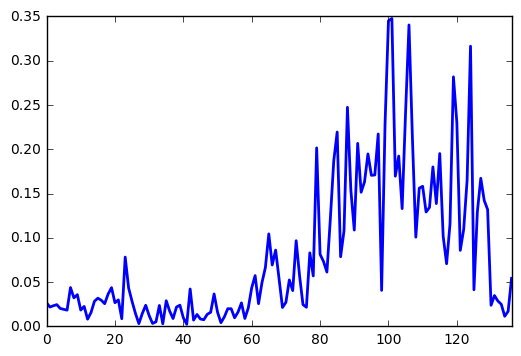

In [19]:
mygdf['ellipticity'].plot()

In [20]:
mygdf['skew'].describe()

count    137.000000
mean       0.188674
std        1.377299
min       -4.330000
25%       -0.295200
50%        0.141000
75%        0.635000
max        6.547000
Name: skew, dtype: float64

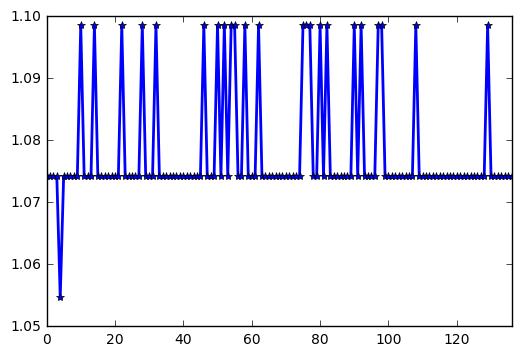

In [21]:
mygdf['frequency'].plot(marker='*')   # tolerance ftol=10%

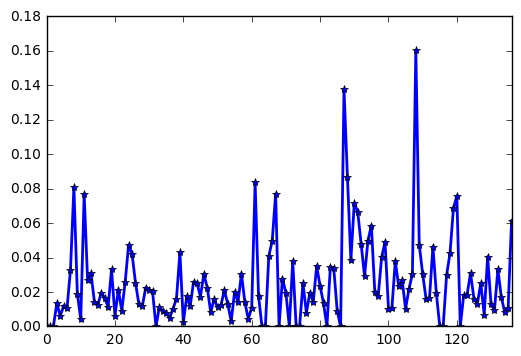

In [22]:
mygdf['tip_mag_re'].plot(marker='*')  

#mygdf['tip_ang_re'].plot(marker='*')  

In [23]:
# output jeojson?

## https://geohackweek.github.io/vector/04-geopandas-intro/

OR

## http://nbviewer.jupyter.org/github/geohackweek/vector/blob/gh-pages/docker/notebooks/geopandas_intro.ipynb
Like shapely, these spatial data types are limited to discrete entities/features and do not address continuously varying rasters or fields.

While GeoPandas spatial objects can be assigned a Coordinate Reference System (CRS), operations can not be performed across CRS’s. Plus, geodetic (“unprojected”, lat-lon) CRS are not handled in a special way; the area of a geodetic polygon will be in degrees.


In [24]:
mygdf.iloc[-1]  # last row or feature

station                        11330a   
lon                               140.38
lat                             -19.2547
phi_min                          35.3685
phi_max                          39.4292
skew                              0.1956
ellipticity                       0.0543
azimuth                          -57.735
tip_mag_re                        0.0613
tip_ang_re                      -160.088
tip_mag_im                        0.0762
tip_ang_im                       136.475
frequency                         1.0742
geometry       POINT (140.3804 -19.2547)
Name: 136, dtype: object

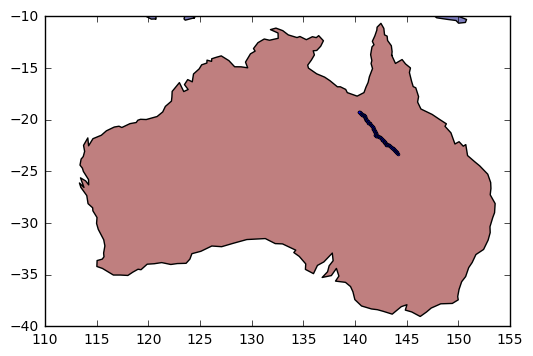

In [25]:
# geopandas included shape datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
myax=world.plot(alpha=0.5)

myax.set_xlim([138,150])
myax.set_ylim([-30,-10])

myax.set_xlim([110,155])
myax.set_ylim([-40,-10])
              
mygdf.plot(ax=myax, figsize=(10, 20), marker='o', color='blue', markersize=2);

# Construct phase_tensor Ellipses and Tippers 

# write to shape files with different projections: wgs84, utm, etc.

In [26]:
import numpy as np
    
from shapely.geometry import Point, Polygon, LineString, LinearRing

def create_tipper_real_shp(csvfile,  arr_size=4):
    """ create tipper lines shape file.  
    Must use a GIS software such as ArcGIS to display and add an arrow at each line's end
    arr_size=4  how long will be the line (arrow)
    """
    
    pdf = pd.read_csv(csvfile)
    mt_locations = [Point(xy) for xy in zip(pdf.lon, pdf.lat)]
    #OR pdf['geometry'] = pdf.apply(lambda z: Point(z.lon, z.lat), axis=1)
    #if you want to df = df.drop(['Lon', 'Lat'], axis=1)
    crs = {'init': 'epsg:4326'}  # WGS84
    
    #geo_df = gpd.GeoDataFrame(pdf, crs=crs, geometry=mt_locations)
    
    pdf['tip_re'] = pdf.apply(lambda x: 
        LineString([(float(x.lon), float(x.lat)), 
                    (float(x.lon)+ arr_size*x.tip_mag_re*np.cos(-np.deg2rad(x.tip_ang_re)),
                     float(x.lat)+ arr_size*x.tip_mag_re*np.sin(-np.deg2rad(x.tip_ang_re)))]), axis=1)


    pdf = gpd.GeoDataFrame(pdf, geometry='tip_re')
    
    return pdf


In [27]:
tipdf=create_tipper_real_shp(path2csv)

tipdf.to_file('tip_re.shp', driver='ESRI Shapefile')

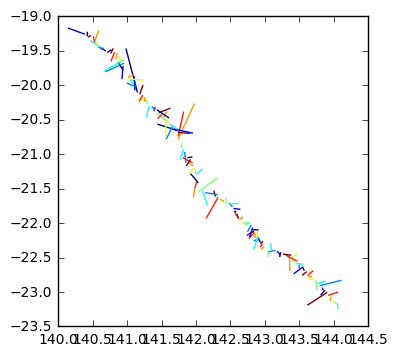

In [28]:
tipdf.plot()

In [29]:
tipdf.head()

,station,lon,lat,phi_min,phi_max,skew,ellipticity,azimuth,tip_mag_re,tip_ang_re,tip_mag_im,tip_ang_im,frequency,tip_re
0,10020,144.1380,-23.2889,36.7190,38.7299,-0.0903,0.0267,-40.8529,0.0000,-180.0000,0.0000,-180.0000,1.0742,"LINESTRING (144.138 -23.2889, 144.138 -23.2889)"
1,10030,144.1123,-23.2511,39.2920,41.0537,0.6350,0.0219,-50.2234,0.0000,-180.0000,0.0000,-180.0000,1.0742,"LINESTRING (144.1123 -23.2511, 144.1123 -23.2511)"
2,10040,144.0786,-23.2121,36.5331,38.2855,0.2622,0.0234,-42.5631,0.0000,-180.0000,0.0000,-180.0000,1.0742,"LINESTRING (144.0786 -23.2121, 144.0786 -23.2121)"
3,10050,144.0539,-23.1816,37.4741,39.3619,0.6237,0.0246,14.3026,0.0135,83.8682,0.0073,-163.6642,1.0742,"LINESTRING (144.0539 -23.1816, 144.05966806006..."
4,10060,144.0249,-23.1491,36.9054,38.4320,0.4813,0.0203,-44.9089,0.0060,50.8057,0.0109,175.0621,1.0547,"LINESTRING (144.0249 -23.1491, 144.04006685292..."


In [30]:

# re-project the geopandas df into different epsg, then write out to shape files.


In [31]:

# http://toblerity.org/shapely/manual.html#polygons
# https://geohackweek.github.io/vector/04-geopandas-intro/
    
from shapely.geometry import Point, Polygon, LinearRing

def create_phase_tensor_ellipse_shp(csvfile, esize=0.03):
    """ create phase tensor ellipse
    esize is ellipse size, defaut 0.03 is about 3KM in the max ellipse rad
    """
    
    pdf = pd.read_csv(csvfile)
    mt_locations = [Point(xy) for xy in zip(pdf.lon, pdf.lat)]
    #OR pdf['geometry'] = pdf.apply(lambda z: Point(z.lon, z.lat), axis=1)
    #if you want to df = df.drop(['Lon', 'Lat'], axis=1)
    crs = {'init': 'epsg:4326'}  # WGS84
    
    pdf = gpd.GeoDataFrame(pdf, crs=crs, geometry=mt_locations)
    
    
    # make  pt_ellispes using polygons
    PHIMAX=pdf['phi_max'].max() # the max of this group of ellipse
    
    print PHIMAX
    
    theta = np.arange(0, 2 * np.pi, np.pi / 30.) # points to trace out the polygon-ellipse
 
    azimuth = -np.deg2rad(pdf['azimuth'])
    width = esize * (pdf['phi_max'] /PHIMAX)
    height = esize * (pdf['phi_min'] / PHIMAX)
    x0 = pdf['lon']
    y0 = pdf['lat']

# apply formula to generate ellipses
  
    ellipse_list=[]
    for i in xrange(0, len(azimuth)):
        x = x0[i] + height[i] * np.cos(theta) * np.cos(azimuth[i]) - width[i] * np.sin(theta) * np.sin(azimuth[i])
        y = y0[i] + height[i] * np.cos(theta) * np.sin(azimuth[i]) + width[i] * np.sin(theta) * np.cos(azimuth[i])

        polyg= Polygon(LinearRing([xy for xy in zip(x, y) ]))
        
        #print polyg  # an ellispe
        
        ellipse_list.append(polyg)
        
    
#     for xi, yi in zip(x, y):
#         polyg.(np.round(xi, 6), np.round(yi, 6))
        
        
#                     # 1) make a geometry shape of the ellipse
#                     ellipse = ogr.Geometry(ogr.wkbLinearRing)
#                     ellipse.CloseRings()

#                     # 2) make a polygon
#                     poly = ogr.Geometry(ogr.wkbPolygon)
#                     poly.AddGeometry(ellipse)

#                     poly_list.append(poly)

    pdf = gpd.GeoDataFrame(pdf, crs=crs, geometry=ellipse_list)
    
    return pdf

In [34]:
CSVDIR='E:/Data/MT_Datasets/WenPingJiang_SHP/'

csvfiles=glob.glob(CSVDIR+'/*.csv')

print (len(csvfiles))
for acsv in csvfiles:
    p = create_phase_tensor_ellipse_shp(acsv)
    
    #p.plot()
    shp_fname = acsv.replace('.csv','.shp')
    
    p.to_file(shp_fname, driver='ESRI Shapefile')
    
    

174
88.4225
89.6761
89.8163
89.3456
89.0119
86.4425
89.7583
87.3411
89.9658
89.836
89.836
88.6803
88.6803
87.8746
87.8746
85.5813
85.5813
87.8632
87.8632
87.8632
87.2819
87.2819
87.2819
81.0509
81.0509
81.0509
86.6434
86.6434
85.5797
85.5797
77.9701
77.9701
76.6435
78.0663
78.0663
76.4373
76.4373
76.4373
76.9178
76.9178
76.9178
75.5463
75.5463
75.5463
71.2911
71.2911
62.4339
70.141
70.141
71.4986
71.4986
71.4986
64.264
60.7954
60.7954
60.7954
59.2562
59.2562
59.2562
53.5092
44.5965
49.9971
49.9971
49.9971
46.4079
46.4079
46.4079
44.8393
44.8393
44.8393
44.8393
44.6149
44.6149
39.6753
45.6352
45.6352
43.6684
43.6684
45.2579
45.2579
45.2579
47.711
47.711
47.711
47.711
49.465
49.465
49.465
51.4732
51.4732
51.4732
51.4732
54.2988
54.2988
54.2988
54.6606
54.6606
52.0925
56.3638
59.9746
69.6053
56.3638
57.5247
51.8558
50.0099
73.5769
62.7083
56.284
60.0984
60.0984
56.284
56.284
62.2491
60.7469
56.5736
60.7469
63.6386
60.7469
59.937
54.6606
52.2231
49.3285
49.3285
52.109
51.8356
51.8356
57.11

In [35]:
p.columns

Index([u'station', u'lon', u'lat', u'phi_min', u'phi_max', u'skew',
       u'ellipticity', u'azimuth', u'tip_mag_re', u'tip_ang_re', u'tip_mag_im',
       u'tip_ang_im', u'frequency', u'geometry'],
      dtype='object')

In [ ]:
Pause

In [ ]:
p.head()

In [ ]:

p.to_file('pt_ellispe.shp', driver='ESRI Shapefile')


In [ ]:
p.plot()

In [ ]:
print p.crs

In [ ]:
mygdf28354=p.to_crs({'init':'epsg:28354'})  # utm zone54  long=138-144

In [ ]:
mygdf28354.plot()

In [ ]:
mygdf3112=p.to_crs({'init':'epsg:3112'})  #EPSG:3112 is GDA94 Lambert Confomal (GA LCC)

In [ ]:
mygdf3112.plot()

In [ ]:
mygdf3112.crs

In [ ]:
mygdf3112.head(5)